In [1]:
from datetime import datetime, timedelta
import os

from google.cloud import bigquery
from google.cloud import storage
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from tqdm import tqdm

gcp_cred = f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = gcp_cred

project_id = 'gcp-wow-rwds-ai-mmm-super-dev'
bq = bigquery.Client(project=project_id)

# PREPARE DATA

In [2]:
WINDOW = 12 * 7 
START_DATE = '2021-04-26'
END_DATE = '2021-04-26'
SAMPLE_SIZE = 20000
SAMPLE_PATH = 'sample.parquet'

### Getting samples
We are storing the sample in big query so we can reuse the same sample to generate different feature sets:
1. CNN feature sets (historic transactions)
2. FC feature sets (current offer data)

I have avoided multipliers for now because they are harder to process.

In [3]:
# sql = f"""
#     CREATE OR REPLACE TABLE `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_POST_BQ_MASTER_AUDIENCE_SAMPLE` AS
#     SELECT DISTINCT crn
#     FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
#     WHERE offer_type NOT IN ('MP1', 'MP3', 'TM') -- remove complexity first
#         AND campaign_start_date >= '{START_DATE}'
#         AND campaign_start_date <= '{END_DATE}'
#     ORDER BY RAND()
#     LIMIT {SAMPLE_SIZE}
# """
# bq.query(sql).result()

##### 1. Transaction dataset

The historic transaction data will be consumed by 1-D CNN. `Spend`, in the absence of any offer, can also be used as the target variable for those not getting any offer.

**Issue**: The spend here is not consistent with the evaluation of wkly spend from `MMM_POST_BQ_MASTER_AUDIENCE_SAMPLE`. Need to align.

In [4]:
# if not os.path.isfile(SAMPLE_PATH):

sql = f"""
    WITH txn_dates AS
    (
        SELECT *
        FROM UNNEST(GENERATE_DATE_ARRAY('{START_DATE}'- {WINDOW}, '{END_DATE}', INTERVAL 7 DAY)) AS txn_date
    ), 
    base AS 
    (
        SELECT crn, txn_date
        FROM `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_POST_BQ_MASTER_AUDIENCE_SAMPLE` CROSS JOIN txn_dates
    ), 
    offer_data AS 
    (
        SELECT 
            b.crn, 
            b.campaign_start_date, 
            b.offer_type, 
            b.Model, 
            CAST(b.campaign_week_nbr AS INT) AS campaign_week_nbr,
            b.AVG_SPEND_BAND_L, 
            b.AVG_SPEND_BAND_H, 
            b.spend_hurdle, 
            CASE WHEN b.spend_type ='' THEN NULL ELSE b.spend_type END AS spend_type, 
            b.rewards, 
            b.redeem_flag,
        FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE` b
            JOIN `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_POST_BQ_MASTER_AUDIENCE_SAMPLE` s
                ON b.crn = s.crn
        WHERE b.offer_type NOT IN ('MP1', 'MP3', 'TM') -- remove complexity first
            AND b.post_week_flag = 0
    ), 
    txn_data AS
    (
        SELECT
            lcd.crn, 
            DATE_TRUNC(ass.start_txn_date, WEEK(MONDAY)) as txn_date,
            SUM(ass.tot_amt_incld_gst) AS spend
        FROM `wx-bq-poc.loyalty.article_sales_summary` ass
            JOIN `wx-bq-poc.loyalty.lylty_card_detail` lcd
                ON ass.lylty_card_nbr = lcd.lylty_card_nbr
            JOIN `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_POST_BQ_MASTER_AUDIENCE_SAMPLE` s
                ON lcd.crn = s.crn
        WHERE ass.lylty_card_nbr <> '0'
            AND lcd.crn IS NOT NULL
            AND ass.start_txn_date >= '{START_DATE}' - {WINDOW}
            AND ass.start_txn_date <= '{END_DATE}'
        GROUP BY 1,2
    ), 
    txn_data_fillna AS
    (
        SELECT 
            b.crn, 
            b.txn_date,
            IFNULL(spend, 0) AS spend
        FROM 
            base b 
            LEFT JOIN txn_data td
                ON b.crn = td.crn AND b.txn_date = td.txn_date
    )
    SELECT 
        td.crn,
        td.txn_date, 
        td.spend,
        od.* EXCEPT(crn, campaign_start_date, campaign_week_nbr)
    FROM txn_data_fillna AS td 
        LEFT JOIN offer_data od
            ON td.crn = od.crn AND od.campaign_start_date + 7 * (od.campaign_week_nbr - 1) = td.txn_date
    ORDER BY crn, txn_date 
"""
hist_df = bq.query(sql).result().to_dataframe()
hist_df['spend'] = hist_df['spend'].astype(float)
# hist_df.to_parquet(SAMPLE_PATH, index=False)
# else:
#     sample_df = pd.read_parquet('sample.parquet')

In [5]:
hist_df

crn    txn_date   spend offer_type Model  \
0       1000000000000000632  2021-02-01  150.32        SS2     M   
1       1000000000000000632  2021-02-08   98.17        SS2     M   
2       1000000000000000632  2021-02-15  206.04       None  None   
3       1000000000000000632  2021-02-22  159.25       None  None   
4       1000000000000000632  2021-03-01    0.00       None  None   
...                     ...         ...     ...        ...   ...   
262778  3300000000005004394  2021-03-29  206.33       None  None   
262779  3300000000005004394  2021-04-05   61.01       None  None   
262780  3300000000005004394  2021-04-12  107.46       None  None   
262781  3300000000005004394  2021-04-19  115.59       None  None   
262782  3300000000005004394  2021-04-26   10.05        SGU     M   

        AVG_SPEND_BAND_L  AVG_SPEND_BAND_H spend_hurdle spend_type rewards  \
0                  80.00             89.99          110      multi     950   
1                  80.00             89.99          110      multi     950   
2                    NaN               NaN         None       None    None   
3                    NaN               NaN         None       None    None   
4                    NaN               NaN         None       None    None   
...                  ...               ...          ...        ...     ...   
262778               NaN               NaN         None       None    None   
262779               NaN               NaN         None       None    None   
262780               NaN               NaN         None       None    None   
262781               NaN               NaN         None       None    None   
262782             20.01             40.00           50     single    1200   

        redeem_flag  
0               0.0  
1               0.0  
2               NaN  
3               NaN  
4               NaN  
...             ...  
262778          NaN  
262779          NaN  
262780          NaN  
262781          NaN  
262782          0.0  

[262783 rows x 11 columns]

##### 2. Current (campaign) dataset
Getting the offer meta data for current offer, for which we do not yet have transactions

In [6]:
sql = f"""
    SELECT 
        b.crn, 
        b.campaign_start_date, 
        b.offer_type, 
        b.AVG_SPEND_BAND_L, 
        b.AVG_SPEND_BAND_H, 
        b.spend_hurdle, 
        CASE WHEN b.spend_type ='' THEN NULL ELSE b.spend_type END AS spend_type, 
        b.rewards,
        b.redeem_flag AS redeem_target,
        b.as_wkly_spd_avg AS spend_target
    FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_FINAL_FEATURES_CAMP` b
        JOIN `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_POST_BQ_MASTER_AUDIENCE_SAMPLE` s
            ON b.crn = s.crn
    WHERE b.offer_type NOT IN ('MP1', 'MP3', 'TM') -- remove complexity first
        AND b.campaign_start_date >= '{START_DATE}' 
        AND b.campaign_start_date <= '{END_DATE}'
    ORDER BY crn, campaign_start_date
"""
curr_df = bq.query(sql).result().to_dataframe()

In [7]:
curr_df.head()

crn campaign_start_date offer_type  AVG_SPEND_BAND_L  \
0  1000000000000000632          2021-04-26        SGU            160.01   
1  1000000000000001096          2021-04-26        SS2             80.00   
2  1000000000000001203          2021-04-26        SGU             80.01   
3  1000000000000001500          2021-04-26        SS2            160.00   
4  1000000000000002001          2021-04-26        SS1             10.01   

   AVG_SPEND_BAND_H  spend_hurdle spend_type  rewards  redeem_target  \
0            180.00         200.0      multi   4000.0              0   
1             89.99         110.0      multi    950.0              0   
2            100.00         115.0      multi   2300.0              0   
3            169.99         185.0      multi   1600.0              0   
4             30.00          50.0     single   1000.0              0   

   spend_target  
0     25.573333  
1    147.990000  
2     37.180000  
3    161.313333  
4     12.310000

### PREPROCESSING
We will one-hot-encode the categorical features.

In [8]:
ohes = {}
ohe_feats = {}
for col in ['offer_type', 'Model', 'spend_type']:
    ohe = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(hist_df[[col]])
    ohe_feat = ohe.transform(hist_df[[col]])
    ohe_feats[col] = pd.DataFrame(ohe_feat, columns=[col.lower()+'_'+x[3:].lower().replace(' ','_') for x in ohe.get_feature_names()]) 
    ohes[col] = ohe

In [9]:
# PREPROCESS AND ENCODE HISTORY
hfeat_df = hist_df.copy()
hfeat_df['rewards'] = hfeat_df['rewards'].astype(float)
hfeat_df['spend_hurdle'] = hfeat_df['spend_hurdle'].astype(float)

ohe_feats_combined = ohe_feats['offer_type'].merge(
    ohe_feats['Model'], how='inner', left_index=True, right_index=True).merge(
    ohe_feats['spend_type'], how='inner', left_index=True, right_index=True
)
hfeat_df.drop(columns=['offer_type', 'Model', 'spend_type'], inplace=True)
hfeat_df = hfeat_df.merge(ohe_feats_combined, how='inner', left_index=True, right_index=True)
hfeat_df.fillna(0, inplace=True)

# temporary patch - removing duplicated campaign data -_-
hfeat_df.drop_duplicates(['crn', 'txn_date'], inplace=True)
hfeat_df.reset_index(drop=True, inplace=True)

In [10]:
# PREPROCESS AND ENCODE CURRENT
cfeat_df = curr_df.copy()
cfeat_df['rewards'] = cfeat_df['rewards'].astype(float)
cfeat_df['spend_hurdle'] = cfeat_df['spend_hurdle'].astype(float)

ohe_feats_combined = ohe_feats['offer_type'].merge(
    ohe_feats['spend_type'], how='inner', left_index=True, right_index=True
)
cfeat_df.drop(columns=['offer_type', 'spend_type'], inplace=True)
cfeat_df = cfeat_df.merge(ohe_feats_combined, how='inner', left_index=True, right_index=True)
cfeat_df.fillna(0, inplace=True)

In [11]:
cfeat_df.head()

crn campaign_start_date  AVG_SPEND_BAND_L  \
0  1000000000000000632          2021-04-26            160.01   
1  1000000000000001096          2021-04-26             80.00   
2  1000000000000001203          2021-04-26             80.01   
3  1000000000000001500          2021-04-26            160.00   
4  1000000000000002001          2021-04-26             10.01   

   AVG_SPEND_BAND_H  spend_hurdle  rewards  redeem_target  spend_target  \
0            180.00         200.0   4000.0              0     25.573333   
1             89.99         110.0    950.0              0    147.990000   
2            100.00         115.0   2300.0              0     37.180000   
3            169.99         185.0   1600.0              0    161.313333   
4             30.00          50.0   1000.0              0     12.310000   

   offer_type_2c  offer_type_4c  offer_type_ra  offer_type_sgu  \
0            0.0            0.0            0.0             0.0   
1            0.0            0.0            0.0             0.0   
2            0.0            0.0            0.0             0.0   
3            0.0            0.0            0.0             0.0   
4            0.0            0.0            0.0             0.0   

   offer_type_ss1  offer_type_ss2  offer_type_none  spend_type_multi  \
0             0.0             1.0              0.0               1.0   
1             0.0             1.0              0.0               1.0   
2             0.0             0.0              1.0               0.0   
3             0.0             0.0              1.0               0.0   
4             0.0             0.0              1.0               0.0   

   spend_type_single  spend_type_none  
0                0.0              0.0  
1                0.0              0.0  
2                0.0              1.0  
3                0.0              1.0  
4                0.0              1.0

### GETTING TARGET
So the target is basically composed of two things:
1. `as_spd_weekly_avg` from campaign when the crn is exposed to a CVM offer
2. `spend` from transaction data when the crn is not exposed to any CVM offer

Two potential issues: 
1. `spend` from transaction table is not aligned with `weekly spend` from campaign table. 
2. `as_spd_weekly_avg` is an average of promo-week and post-week, but `spend` is simply a sum over a week - does this matter?

In [12]:
start_date = pd.to_datetime(START_DATE).date()
end_date = pd.to_datetime(END_DATE).date()
campaign_start_dates = list(set(curr_df.campaign_start_date))

# target from history table
htarget_df = hist_df[(hist_df.txn_date.isin(campaign_start_dates))]
htarget_df = htarget_df[pd.isna(htarget_df.offer_type)][['crn', 'txn_date', 'redeem_flag', 'spend']]
htarget_df.fillna(0, inplace=True)
htarget_df.rename(columns={
    'txn_date': 'campaign_start_date',
    'redeem_flag': 'redeem_target',
    'spend': 'spend_target'
}, inplace=True)

# target from spend
ctarget_df = curr_df[['crn', 'campaign_start_date', 'redeem_target', 'spend_target']]
target_df = pd.concat([htarget_df, ctarget_df], axis=0)

In [13]:
target_df.head()

crn campaign_start_date  redeem_target  spend_target
0  1000000000000000632          2021-04-26            0.0     25.573333
1  1000000000000001096          2021-04-26            0.0    147.990000
2  1000000000000001203          2021-04-26            0.0     37.180000
3  1000000000000001500          2021-04-26            0.0    161.313333
4  1000000000000002001          2021-04-26            0.0     12.310000

### TODO: Create a dataloader
What we currently have is very not scalable because we are storing data in memory for consumption by the model. Ideally, we should be able to:
- partition the data into different files
- have a dataloader that loads these files and only loads before consumption by the model

In [14]:
assert hfeat_df.crn.nunique() == cfeat_df.crn.nunique()
assert hfeat_df.crn.nunique() == target_df.crn.nunique()

In [15]:
# class CustomDataGen(tf.keras.utils.Sequence):
    
#     def __init__(self, hist_df, curr_df, target_df,
#                  batch_size,
#                  input_size=(224, 224, 3),
#                  shuffle=True):
        
#         self.hist_df = hist_df
#         self.curr_df = curr_df
#         self.target_df = target_df
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.n = len(self.target.df)
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df = self.df.sample(frac=1).reset_index(drop=True)
    
#     def __get_input(self, path, bbox, target_size):
#         pass
    
#     def __get_output(self, label, num_classes):
#         pass
    
#     def __get_data(self, batches):
#         # Generates data containing batch_size samples
        
#         X_h = batches.merge

#         path_batch = batches[self.X_col['path']]
#         bbox_batch = batches[self.X_col['bbox']]
        
#         name_batch = batches[self.y_col['name']]
#         type_batch = batches[self.y_col['type']]

#         X_batch = np.asarray([self.__get_input(x, y, self.input_size) for x, y in zip(path_batch, bbox_batch)])

#         y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])
#         y1_batch = np.asarray([self.__get_output(y, self.n_type) for y in type_batch])

#         return tuple(X_h, X_c), y_batch
    
#     def __getitem__(self, index):
        
#         batches = self.target_df[index * self.batch_size:(index + 1) * self.batch_size]
#         X, y = self.__get_data(batches)        
#         return X, y
    
#     def __len__(self):
#         return self.n // self.batch_size



In [16]:
# crn_list = list(target_df.crn.unique())

# def my_generator():
#     for dt in campaign_start_dates:
#         hfeat_dt = hfeat_df[np.logical_and(hfeat_df.txn_date >= dt - timedelta(days=WINDOW), hfeat_df.txn_date < dt)]
#         cfeat_dt = cfeat_df[cfeat_df.campaign_start_date == dt]
#         target_dt = target_df[target_df.campaign_start_date == dt]
#         for crn in crn_list:
#             hfeat_crn = hfeat_dt[hfeat_dt.crn==crn].iloc[:,2:].values
#             cfeat_crn = cfeat_dt[cfeat_dt.crn==crn].iloc[:,2:].values
#             target_crn = target_dt[target_dt.crn==crn].iloc[:,2:].values
#             yield np.expand_dims(hfeat_crn, axis=0), cfeat_crn, target_crn

### In memory data-loader
Not practical for full training - but for prototyping should be ok?

In [17]:
n_cfeatures = cfeat_df.shape[1] - 2
n_hfeatures = hfeat_df.shape[1] - 2
n_timesteps = WINDOW // 7

In [18]:
cfeat = cfeat_df.iloc[:,2:].values

crn_list = list(hfeat_df.crn.unique())
hfeat = hfeat_df[hfeat_df.crn==crn_list[0]].reset_index(drop=True)
hfeat = hfeat.iloc[:n_timesteps,2:].values
hfeat = np.expand_dims(hfeat, axis=0)

for crn in crn_list[1:]:
    _hfeat = hfeat_df[hfeat_df.crn==crn].reset_index(drop=True)
    _hfeat = _hfeat.iloc[:n_timesteps, 2:].values
    _hfeat = np.expand_dims(_hfeat, axis=0)
    hfeat = np.concatenate((hfeat,_hfeat), axis=0)
    
target = target_df.iloc[:,2:].values

cfeat = tf.convert_to_tensor(cfeat, dtype=tf.float32)
hfeat = tf.convert_to_tensor(hfeat, dtype=tf.float32)
target = tf.convert_to_tensor(target, dtype=tf.float32)
target = tf.expand_dims(target[:,1], axis=1)

In [41]:
train_size = 0.8
split = int(round(train_size * len(target),0))

hfeat_train = hfeat[:split]
cfeat_train = cfeat[:split]
target_train = target[:split]

hfeat_test = hfeat[split:]
cfeat_test = cfeat[split:]
target_test = target[split:]

# Modelling

In [20]:
class SpendCNN(Model):
    
    def __init__(self, n_timesteps, n_hfeatures, n_cfeatures, **kwargs):
        super(SpendCNN, self).__init__(**kwargs)
        
        # Input layers
        self.hist_input = Input(shape=(n_timesteps, n_hfeatures), name="history")  
        self.curr_input = Input(shape=(n_cfeatures), name="current")  
        
        # Hidden layers
        self.dense_1 = layers.Dense(8, activation="relu")
        self.dense_2 = layers.Dense(8, activation="relu")
        
        self.cnn_1 = layers.Conv1D(8, 4, activation="relu")
        self.cnn_2 = layers.Conv1D(8, 4, activation="relu")
        self.cnn_3 = layers.Conv1D(8, 4, activation="relu")
        
        self.dense_n = layers.Dense(1, activation="relu")
#         self.dense_3 = layers.Dense(1, activation="sigmoid")

    def get_model(self):
        
        x_h = self.cnn_1(self.hist_input)
        x_h = self.cnn_2(x_h)
        x_h = layers.Flatten()(x_h)
        
        x_c = self.dense_1(self.curr_input)
        x_c = self.dense_2(x_c)
        
        x = layers.concatenate([x_h, x_c])
        y_spd = self.dense_n(x)
        
        return Model(
            inputs=[self.hist_input, self.curr_input],
            outputs=[y_spd]
        )

    

In [60]:
np.random.seed(0)
tf.random.set_seed(0)

model = SpendCNN(n_timesteps, n_hfeatures, n_cfeatures)
model = model.get_model()
model.summary()

epochs = 10
lr = [1e-3, 1e-4, 1e-5]
train_loss = []
valid_loss = []

for i in range(3):
    model.compile(
        optimizer=keras.optimizers.RMSprop(lr[i]),
        loss=keras.losses.MeanSquaredError(),
    )
    history = model.fit(
        {"history": hfeat_train, "current": cfeat_train},
        target_train,
        validation_data=({"history": hfeat_test, "current": cfeat_test}, target_test),
        epochs=epochs,
        batch_size=32,
        shuffle=True,
    )
    train_loss += history.history['loss']
    valid_loss += history.history['val_loss']
    

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, 12, 19)]     0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 9, 8)         616         history[0][0]                    
__________________________________________________________________________________________________
current (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 6, 8)         264         conv1d_15[0][0]                  
____________________________________________________________________________________________

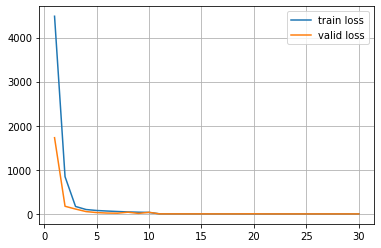

In [64]:
x = range(1, epochs*len(lr)+1)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, valid_loss, label='valid loss')
plt.legend()
plt.grid()
plt.show()